In [1]:
#import libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import glob
import os

In [2]:
# Setting up batch size
b_size = 32

# Setting up image size
i_size = 256

# Setting up channels 
channels=3

# Setting up epochs
epochs=10

In [3]:

#preprocessing images in directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "image_dataset",
    #shuffling the dataset
    shuffle=True,
    #resizing image size
    image_size=(i_size,i_size),
    #setting batch size
    batch_size=b_size
)

Found 31269 files belonging to 17 classes.


In [4]:
#getting classes names
class_names = dataset.class_names
class_names

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
len(dataset)

978

In [6]:
#printing img_btch shape and labls
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5 11 13  3 14  6  1  6 13 16 15 16 13  7  7 10  9 13 16 14  3  4 13  9
  7  6 12  0 16 12  0 15]


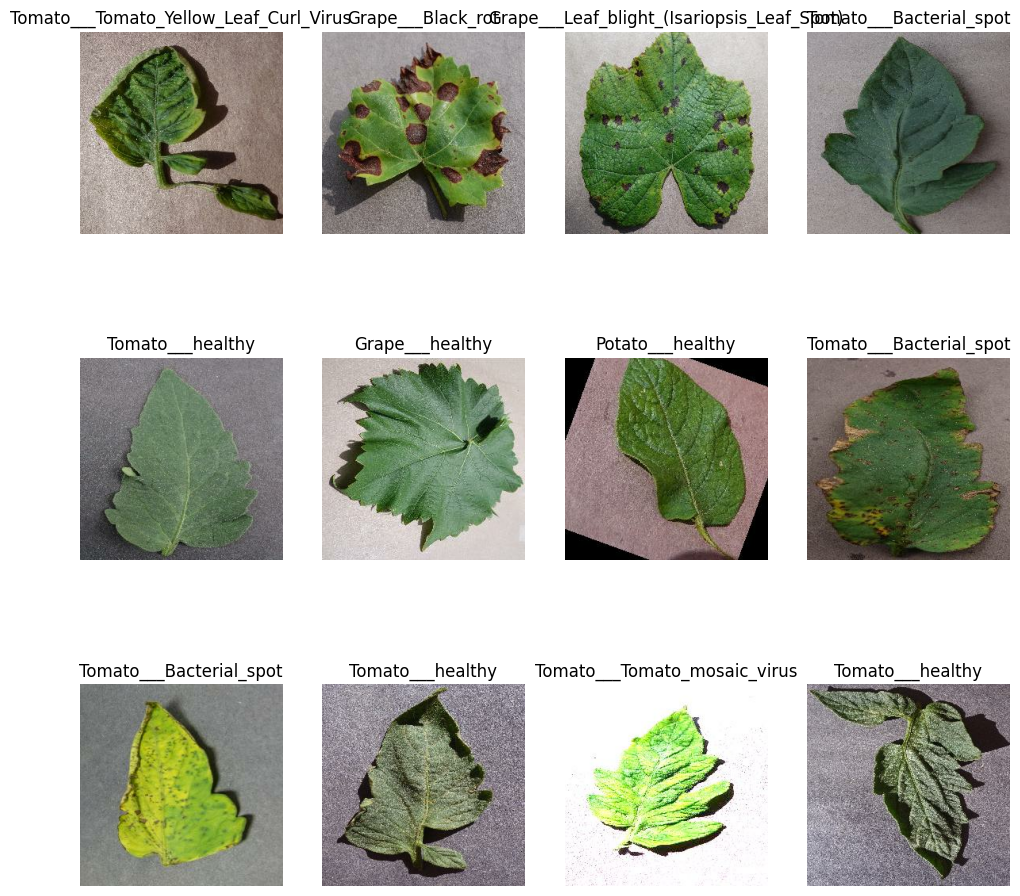

In [7]:
#plotting images from dataset
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

978

In [9]:
#80% --> train
#20% --> 10% validation, 10% test
#train_size ==> 0.8
batches_c=int(len(dataset)*0.8)

#validation_size==>0.1
val_c=int(len(dataset)*0.1)

#test_size==>0.1
test_c=int(len(dataset)*0.1)

In [10]:
# Define function split dataset training set, validation set, test set

def get_dataset_partitions_tf(dataset_name, train_data_size, val_data_size, test_data_size, shuffle=True, shuffle_size=10000):

    # Calculate length of the dataset
    dataset_size = len(dataset_name)
    #check sum of the dataset is correct
   
        
    #shuffle the dataset to randomize the order of the dataset
    if shuffle:
        dataset_name = dataset_name.shuffle(shuffle_size, seed=5)
    
    #split dataset training set, validation set, test set
    train_dataset = dataset_name.take(train_data_size)    
    validation_dataset = dataset_name.skip(train_data_size).take(val_data_size)
    test_dataset = dataset_name.skip(train_data_size).skip(test_data_size)
    
    return train_dataset, validation_dataset, test_dataset

In [11]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset,batches_c,val_c,test_c)

In [12]:
len(train_dataset)

782

In [13]:
len(validation_dataset)

97

In [14]:
len(test_dataset)

99

In [15]:
#optimize training performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#resize and rescaling images
resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(i_size, i_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
#define data augmentation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
#applying data augmentation to training dataset and prefetching data
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# defining the shape, classes count, and create model

input_shape = (b_size, i_size, i_size, channels)
n_classes = 17

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Build model with the specified input shape
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_dataset,
    batch_size=b_size,
    validation_data=validation_dataset,
    verbose=1,
    epochs=6,
)

Epoch 1/6
782/782 [==============================] - 304s 316ms/step - loss: 2.1545 - accuracy: 0.2759 - val_loss: 1.7770 - val_accuracy: 0.4272
Epoch 2/6
782/782 [==============================] - 189s 242ms/step - loss: 1.0610 - accuracy: 0.6405 - val_loss: 1.3655 - val_accuracy: 0.5854
Epoch 3/6
782/782 [==============================] - 375s 480ms/step - loss: 0.7000 - accuracy: 0.7621 - val_loss: 0.8641 - val_accuracy: 0.7175
Epoch 4/6
782/782 [==============================] - 337s 431ms/step - loss: 0.5489 - accuracy: 0.8113 - val_loss: 0.7369 - val_accuracy: 0.7668
Epoch 5/6
782/782 [==============================] - 264s 338ms/step - loss: 0.4629 - accuracy: 0.8416 - val_loss: 0.8709 - val_accuracy: 0.7490
Epoch 6/6
782/782 [==============================] - 193s 247ms/step - loss: 0.3907 - accuracy: 0.8675 - val_loss: 0.5429 - val_accuracy: 0.8283


In [23]:
#scores = model.evaluate(test_dataset)
model.save("../gratato_modegl.h5")

In [24]:
#scores

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 6, 'steps': 782}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

6

In [30]:
history.history['loss'][:10]

[2.154514789581299,
 1.061020016670227,
 0.699970543384552,
 0.5489049553871155,
 0.46293771266937256,
 0.390658974647522]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

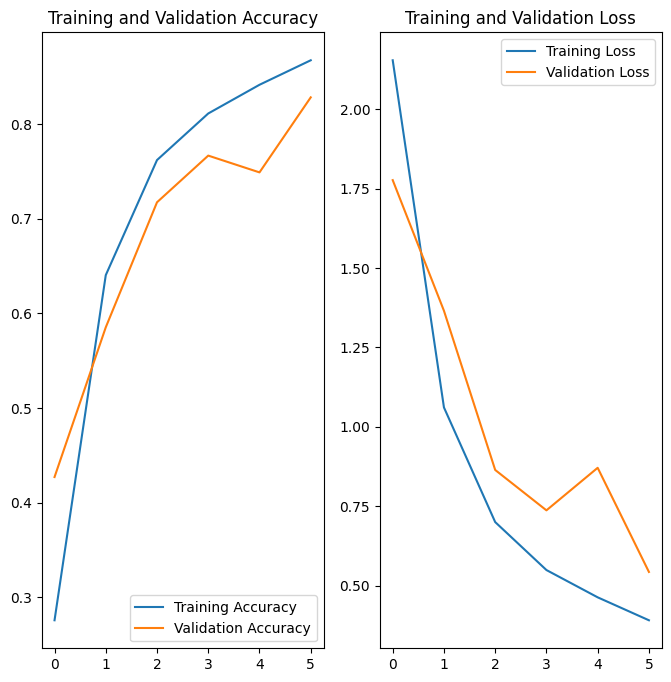

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(6), acc, label='Training Accuracy')
plt.plot(range(6), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(6), loss, label='Training Loss')
plt.plot(range(6), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first img predict
actual : Grape___healthy
predicted : Grape___healthy


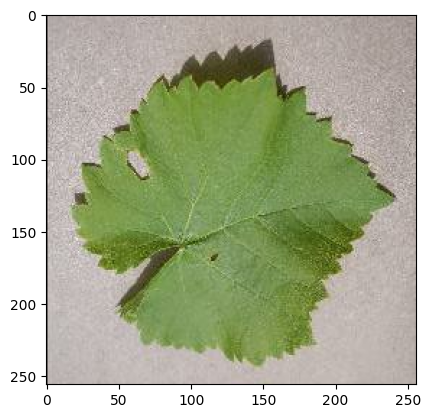

In [33]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first img predict")
    plt.imshow(first_image)
    print("actual :",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted :",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

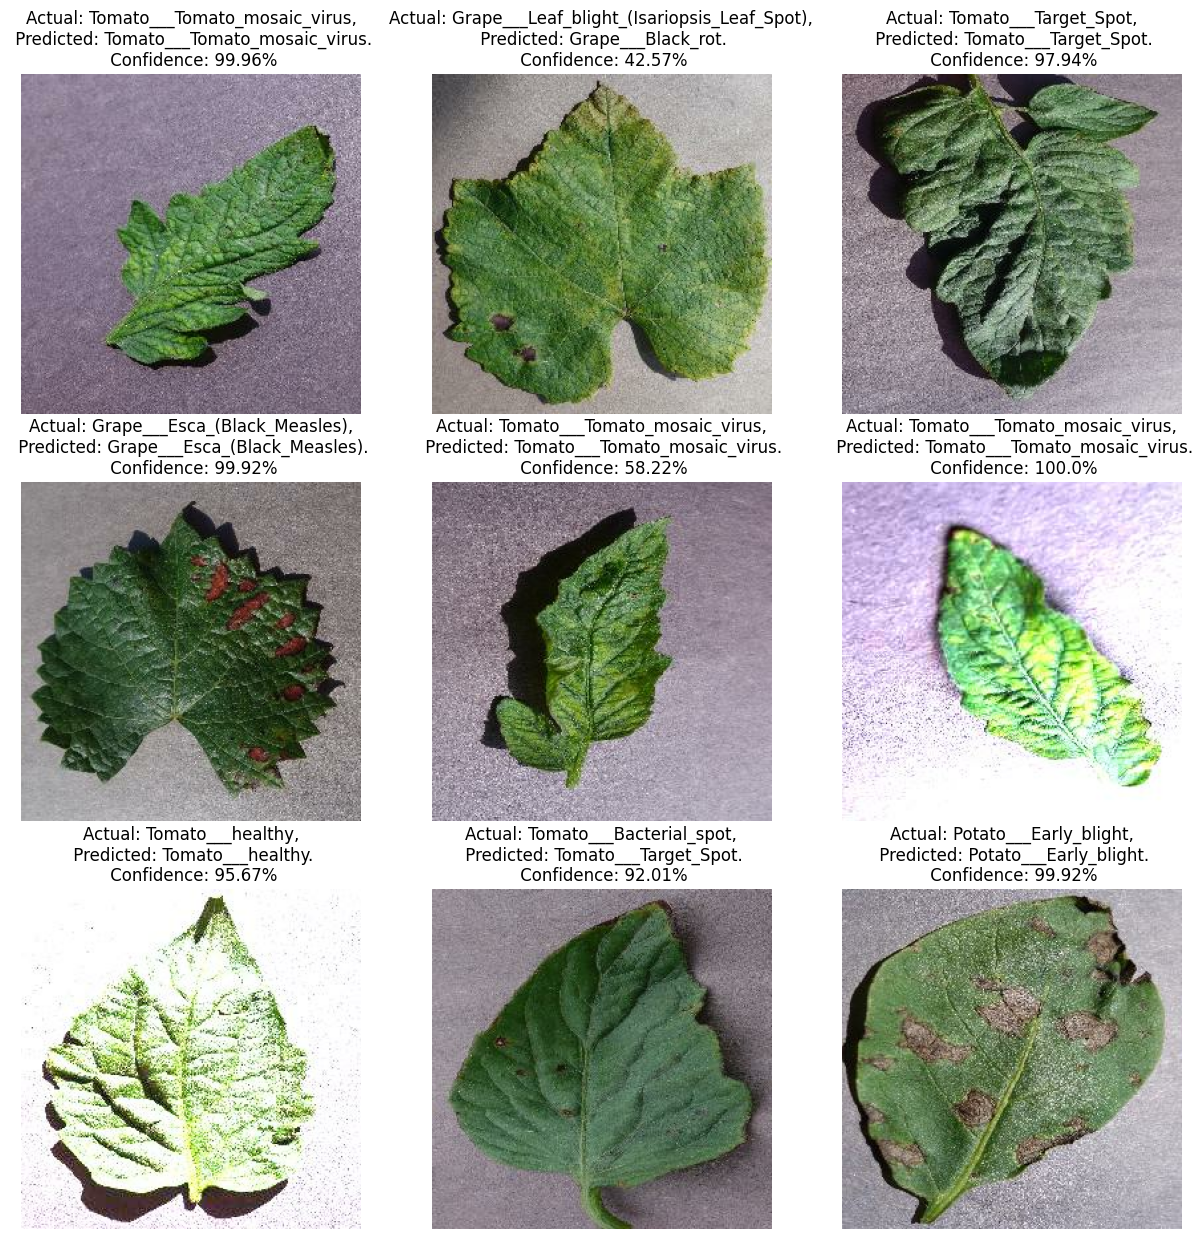

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [42]:
model.save("../gratoto_model_with_wrong_inputs.h5")